In [2]:
!pip3 install torch

    100% |████████████████████████████████| 519.5MB 33kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58790000 @  0x7f554b8ae2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [1]:
from google.colab import files
uploaded = files.upload()

Saving eng-fra.txt to eng-fra.txt


In [0]:
%matplotlib inline

In [3]:
# -*- coding: utf-8 -*-

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pdb
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PAD_token = 0
SOS_token = 1
EOS_token = 2


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 3  # Count PAD, SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s



def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]



def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))


Reading lines...
Read 160872 sentence pairs
Trimmed to 12244 sentence pairs
Counting words...
Counted words:
fra 4786
eng 3117
['tu es fort bonne .', 'you re very good .']


In [0]:
import itertools

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m
  
def inputVar(inputs):
  lengths = [len(sentence) for sentence in inputs]
  return list(itertools.zip_longest(*inputs, fillvalue=0)), torch.tensor(lengths)

def outputVar(outputs):
  out, lengths = inputVar(outputs)
  max_len = torch.max(lengths)
  return out, max_len

def generateBatchTrainData(training_pairs, batch_size=64):
  training_pairs.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
  inputs = []
  targets = []
  for i in range(batch_size):
    tmp_pair = training_pairs[i]
    tmp_inp = [input_lang.word2index[word] for word in tmp_pair[0].split(" ")]
    tmp_inp.append(EOS_token)
    tmp_out = [output_lang.word2index[word] for word in tmp_pair[1].split(" ")]
    tmp_out.append(EOS_token)
    inputs.append(tmp_inp)
    targets.append(tmp_out)
  inp, lengths = inputVar(inputs)
  out, max_len = outputVar(targets)
  mask = binaryMatrix(out)
  return torch.LongTensor(inp), torch.tensor(lengths), torch.LongTensor(out), max_len.item(), torch.ByteTensor(mask)

def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

0m 8s (- 0m 0s) (100 100%) 0.1223
> je suis aime de toute ma famille .
= i am loved by all my family .
< i am loved by all my family . <EOS>

> vous etes une sale menteuse !
= you re a filthy liar !
< you re a filthy liar ! <EOS>

> il adore les chats .
= he s a cat lover .
< he s a cat lover . <EOS>

> je ne suis pas du tout interessee .
= i m not at all interested .
< i m not at at all . <EOS>

> nous allons essuyer une tempete .
= we are going to have a storm .
< we are going to have a storm . <EOS>

> vous etes le professeur .
= you re the teacher .
< you re the teacher . <EOS>

> elle est adorable .
= she s adorable .
< she s adorable . <EOS>

> il a tres peur des chiens .
= he is very afraid of dogs .
< he is very afraid of dogs . <EOS>

> je suis tout a fait eveillee .
= i m wide awake .
< i m wide awake . <EOS>

> je prevois de jouer au football demain .
= i am going to play soccer tomorrow .
< i am going to play soccer tomorrow . <EOS>

> je commence a perdre patience avec tom

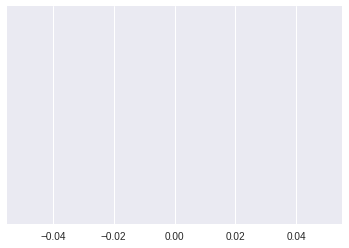

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden, input_len):
        # input: (sentence_len, batch_size)
        embedded = self.embedding(input)
        # embedded: (sentence_len, batch_size, hidden_size)
        # input_len must be a tensor having one dim
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_len)
        outputs, hidden = self.gru(packed, hidden)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # outputs: (sentence_len, batch_size, hidden_size)
        return outputs, hidden

    def initHidden(self, batch_size = 64):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        encoder_outputs = encoder_outputs.transpose(0, 1)
        # attn_weights: (batch_size, 1, max_length)
        # encoder_outputs: (batch_size, ?, hidden_size)
        # there's a problem here: the second dim of encoder_outputs may not be 10
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs)
        # embedded: (1, batch, hidden_size)
        # attn_applied: (batch_sizw, 1, hidden_size)
        output = torch.cat((embedded[0], attn_applied[:, 0, :]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)



def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


teacher_forcing_ratio = 0.5


def train(input_tensor, input_len, target_tensor, target_max, target_mask, batch_size, 
          encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH, clip=50):
    encoder_hidden = encoder.initHidden(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0
    
    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden, input_len)
    if encoder_outputs.size()[0] < max_length:
        tmp_zeros = torch.zeros((max_length - encoder_outputs.size()[0], batch_size, encoder.hidden_size))
        tmp_zeros = tmp_zeros.to(device)
        encoder_outputs = torch.cat((encoder_outputs, tmp_zeros), dim=0)
    decoder_input = torch.tensor([[SOS_token for _ in range(batch_size)]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_max):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_tensor[di], target_mask[di])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
            decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing
            
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_max):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.transpose(1, 0).detach()  # detach from history as input
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_tensor[di], target_mask[di])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    loss.backward()
    
    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    return sum(print_losses) / n_totals



import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))



def trainIters(encoder, decoder, n_iters, batch_size=64, print_every=1000, plot_every=100, learning_rate=0.01, clip=50):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pairs = [random.choice(pairs) for _ in range(batch_size)]
        inputs, input_len, targets, targets_max, mask = generateBatchTrainData(training_pairs, batch_size)
        inputs = inputs.to(device)
        targets = targets.to(device)
        mask = mask.to(device)
        loss = train(inputs, input_len, targets, targets_max, mask, batch_size, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            evaluateRandomly(encoder, decoder)

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)



import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)



def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden(1)        

        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden, torch.tensor([input_length]))

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        if encoder_outputs.size()[0] < max_length:
            tmp_zeros = torch.zeros((max_length - encoder_outputs.size()[0], 1, encoder.hidden_size))
            tmp_zeros = tmp_zeros.to(device)
            encoder_outputs = torch.cat((encoder_outputs, tmp_zeros), dim=0)
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.detach()
        return decoded_words, decoder_attentions



def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


clip = 50
hidden_size = 256
batch_size = 64
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, batch_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
encoder1.load_state_dict(torch.load("encoder.pkl"))
attn_decoder1.load_state_dict(torch.load("attn_decoder.pkl"))
encoder1.train()
attn_decoder1.train()
trainIters(encoder1, attn_decoder1, 100, batch_size, print_every=100, clip=clip)

encoder1.eval()
attn_decoder1.eval()
evaluateRandomly(encoder1, attn_decoder1)


In [0]:
torch.save(encoder1.state_dict(), "encoder.pkl")
torch.save(attn_decoder1.state_dict(), "attn_decoder.pkl")

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


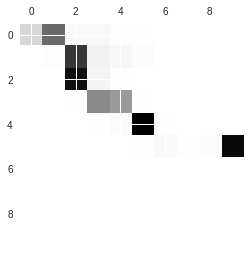

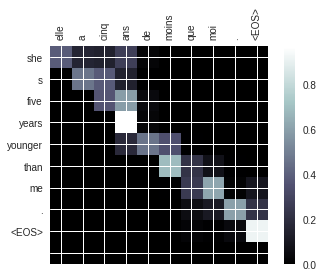

input = elle est trop petit .
output = she s too loud . <EOS>


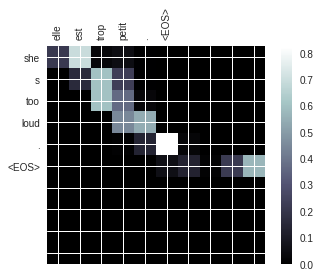

input = je ne crains pas de mourir .
output = i m not scared of dying . <EOS>


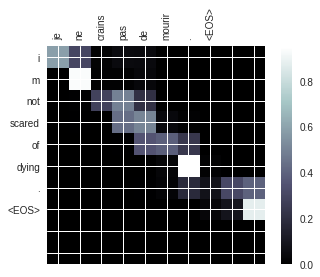

input = c est un jeune directeur plein de talent .
output = he s a talented young director . <EOS>


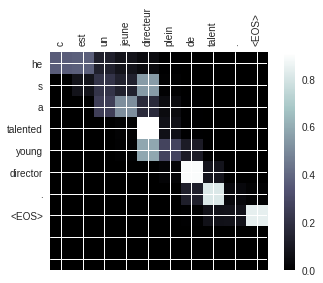

In [14]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())



def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")